In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Download historical data for TSLA, BND, SPY
tickers = ['TSLA', 'BND', 'SPY']
data = yf.download(tickers, start='2010-01-01', end='2023-01-01')['Adj Close']

# Check the first few rows of the data
data.head()


[*********************100%***********************]  3 of 3 completed


Ticker,BND,SPY,TSLA
Date,,,
2010-01-04 00:00:00+00:00,51.721794,86.316010,NaN
2010-01-05 00:00:00+00:00,51.872982,86.544495,NaN
2010-01-06 00:00:00+00:00,51.853249,86.605431,NaN
2010-01-07 00:00:00+00:00,51.813824,86.970985,NaN
2010-01-08 00:00:00+00:00,51.866432,87.260414,NaN


In [ ]:
# Check for missing values and data types
print(data.info())

# Handling missing data: Interpolate missing values (linear interpolation)
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

# Check if there are still any missing values
print(data.isnull().sum())

# Ensure that data is in datetime format (important for time series analysis)
data.index = pd.to_datetime(data.index)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 00:00:00+00:00 to 2022-12-30 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BND     3272 non-null   float64
 1   SPY     3272 non-null   float64
 2   TSLA    3150 non-null   float64
dtypes: float64(3)
memory usage: 102.2 KB
None
Ticker
BND       0
SPY       0
TSLA    122
dtype: int64


In [ ]:
# Calculate basic statistics
basic_stats = data.describe().T
basic_stats['range'] = basic_stats['max'] - basic_stats['min']
print(basic_stats)

         count        mean         std        min         25%         50%  \
Ticker                                                                      
BND     3272.0   65.661039    7.201550  51.721794   60.561440   65.292450   
SPY     3272.0  214.217610  102.339774  78.531410  127.031883  182.632324   
TSLA    3150.0   58.807496   95.526397   1.053333    8.957666   16.222334   

               75%         max       range  
Ticker                                      
BND      69.901285   79.812965   28.091171  
SPY     269.718864  458.720337  380.188927  
TSLA     24.448000  409.970001  408.916668  


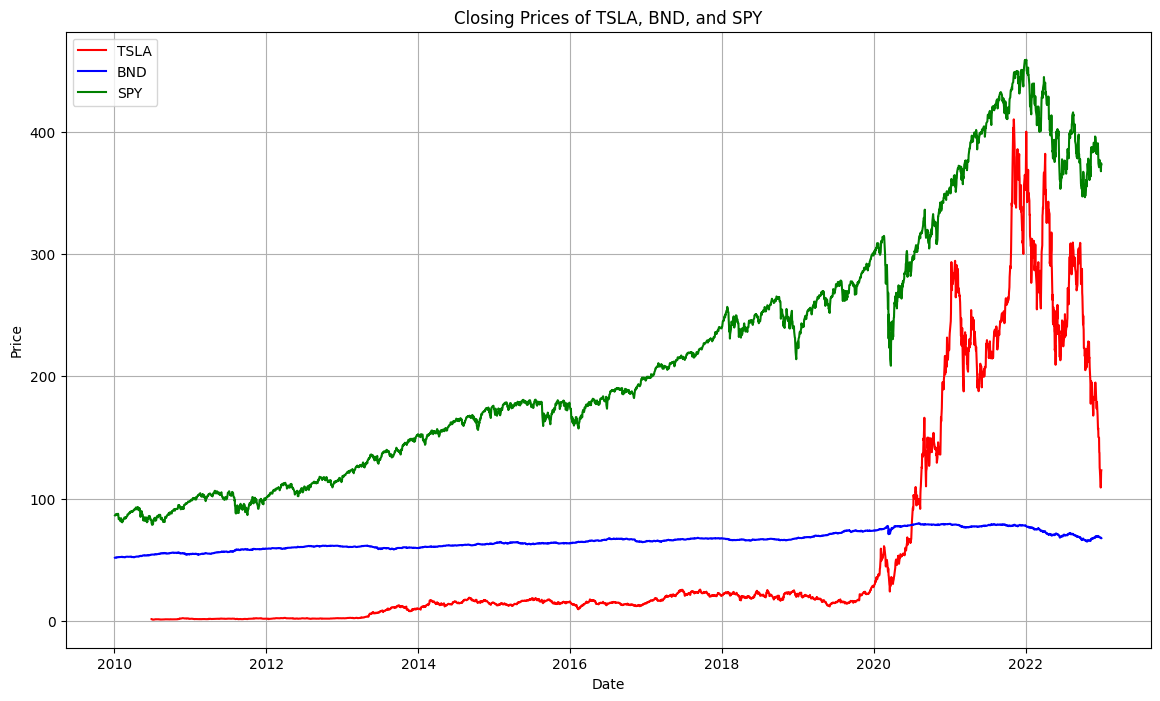

In [ ]:
# Plot closing prices over time for TSLA, BND, and SPY
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['TSLA'], label='TSLA', color='red')
plt.plot(data.index, data['BND'], label='BND', color='blue')
plt.plot(data.index, data['SPY'], label='SPY', color='green')

plt.title('Closing Prices of TSLA, BND, and SPY')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

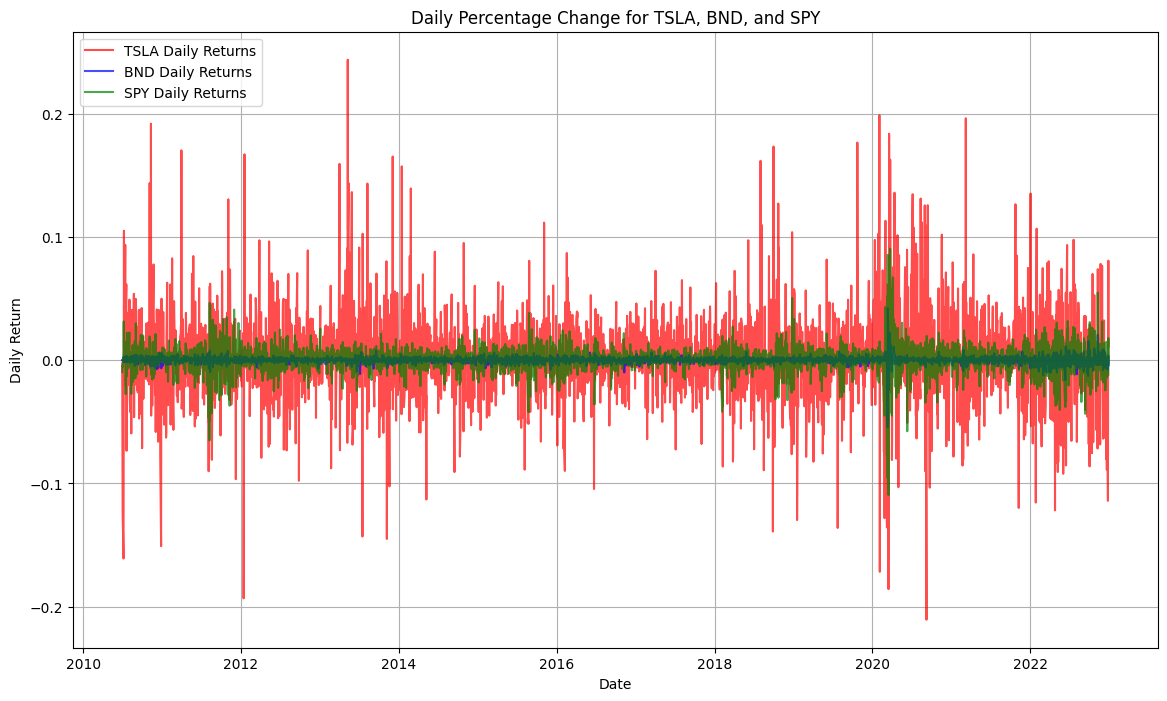

In [ ]:
# Calculate daily percentage change
daily_returns = data.pct_change().dropna()

# Plot daily percentage changes for TSLA, BND, SPY
plt.figure(figsize=(14, 8))
plt.plot(daily_returns.index, daily_returns['TSLA'], label='TSLA Daily Returns', color='red', alpha=0.7)
plt.plot(daily_returns.index, daily_returns['BND'], label='BND Daily Returns', color='blue', alpha=0.7)
plt.plot(daily_returns.index, daily_returns['SPY'], label='SPY Daily Returns', color='green', alpha=0.7)

plt.title('Daily Percentage Change for TSLA, BND, and SPY')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

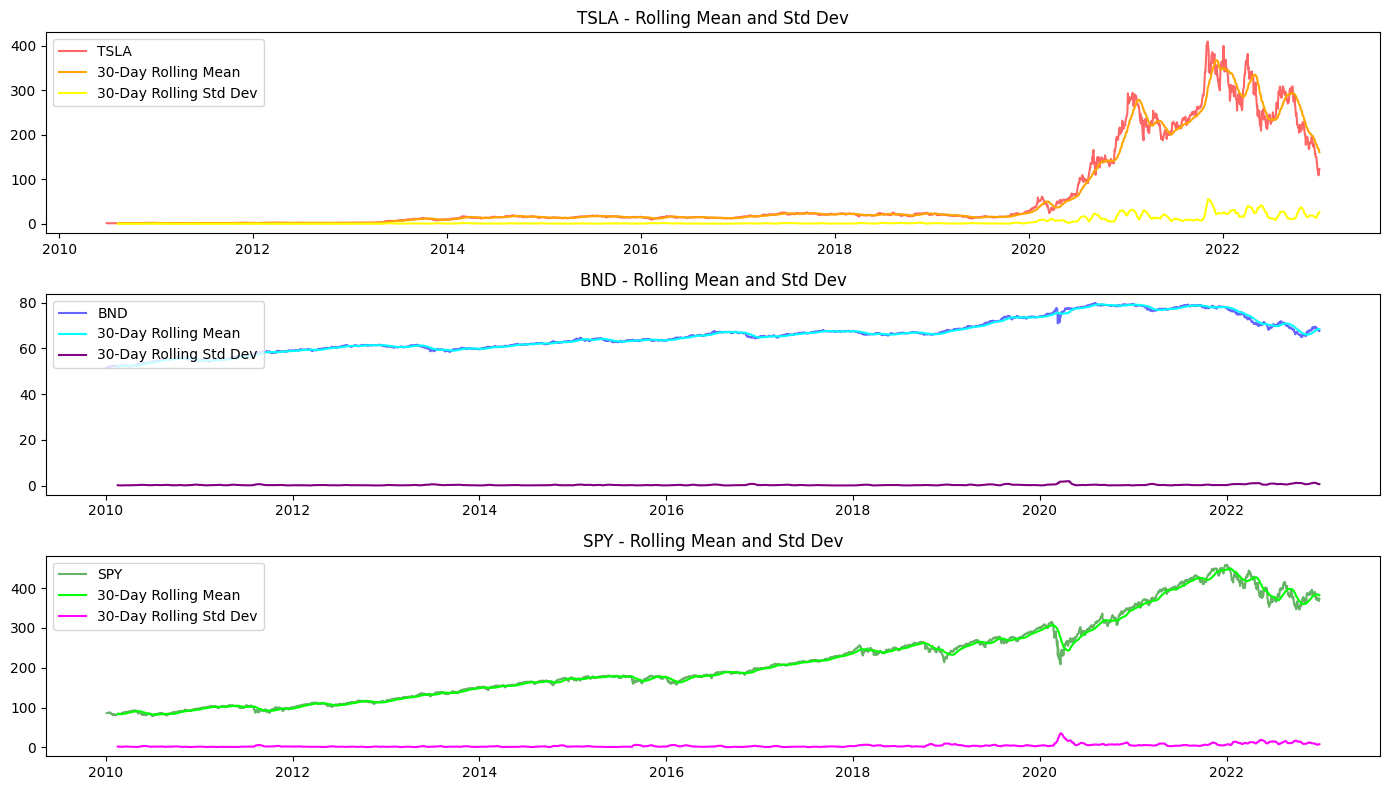

In [ ]:
# Calculate rolling mean and rolling standard deviation (30 days window)
window_size = 30

rolling_mean_tsla = data['TSLA'].rolling(window=window_size).mean()
rolling_std_tsla = data['TSLA'].rolling(window=window_size).std()

rolling_mean_bnd = data['BND'].rolling(window=window_size).mean()
rolling_std_bnd = data['BND'].rolling(window=window_size).std()

rolling_mean_spy = data['SPY'].rolling(window=window_size).mean()
rolling_std_spy = data['SPY'].rolling(window=window_size).std()

# Plot rolling mean and rolling std for TSLA, BND, SPY
plt.figure(figsize=(14, 8))

# TSLA
plt.subplot(3, 1, 1)
plt.plot(data.index, data['TSLA'], label='TSLA', color='red', alpha=0.6)
plt.plot(data.index, rolling_mean_tsla, label='30-Day Rolling Mean', color='orange')
plt.plot(data.index, rolling_std_tsla, label='30-Day Rolling Std Dev', color='yellow')
plt.title('TSLA - Rolling Mean and Std Dev')
plt.legend(loc='upper left')

# BND
plt.subplot(3, 1, 2)
plt.plot(data.index, data['BND'], label='BND', color='blue', alpha=0.6)
plt.plot(data.index, rolling_mean_bnd, label='30-Day Rolling Mean', color='cyan')
plt.plot(data.index, rolling_std_bnd, label='30-Day Rolling Std Dev', color='purple')
plt.title('BND - Rolling Mean and Std Dev')
plt.legend(loc='upper left')

# SPY
plt.subplot(3, 1, 3)
plt.plot(data.index, data['SPY'], label='SPY', color='green', alpha=0.6)
plt.plot(data.index, rolling_mean_spy, label='30-Day Rolling Mean', color='lime')
plt.plot(data.index, rolling_std_spy, label='30-Day Rolling Std Dev', color='magenta')
plt.title('SPY - Rolling Mean and Std Dev')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


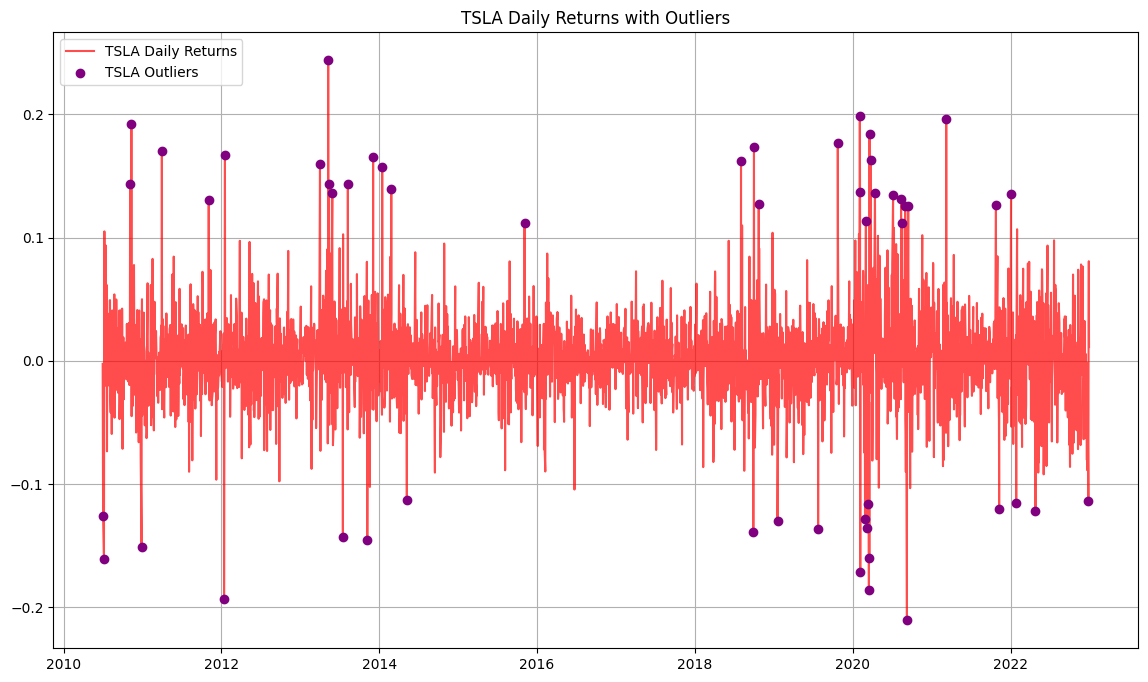

In [ ]:
# Z-Score Calculation to detect outliers in daily returns
z_scores_tsla = np.abs(stats.zscore(daily_returns['TSLA']))
z_scores_bnd = np.abs(stats.zscore(daily_returns['BND']))
z_scores_spy = np.abs(stats.zscore(daily_returns['SPY']))

# Set a threshold for outlier detection (e.g., Z-score > 3)
outliers_tsla = daily_returns['TSLA'][z_scores_tsla > 3]
outliers_bnd = daily_returns['BND'][z_scores_bnd > 3]
outliers_spy = daily_returns['SPY'][z_scores_spy > 3]

# Plotting the outliers on the daily returns plot
plt.figure(figsize=(14, 8))
plt.plot(daily_returns.index, daily_returns['TSLA'], label='TSLA Daily Returns', color='red', alpha=0.7)
plt.scatter(outliers_tsla.index, outliers_tsla, color='purple', label='TSLA Outliers', zorder=5)
plt.title('TSLA Daily Returns with Outliers')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Similar plots for BND and SPY can be done similarly.


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Splitting data into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# ARIMA Forecasting
def arima_forecast(train, test, order=(5, 1, 0)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Exponential Smoothing Forecasting
def es_forecast(train, test, seasonal_periods=12):
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Evaluate Model Performance (MAE, RMSE)
def evaluate_model(true_values, forecast):
    mae = mean_absolute_error(true_values, forecast)
    rmse = sqrt(mean_squared_error(true_values, forecast))
    return mae, rmse

# Forecast for TSLA, BND, SPY using ARIMA and Exponential Smoothing
models = ['TSLA', 'BND', 'SPY']
results = {}

for model in models:
    # ARIMA Forecasting
    arima_forecast_tsla = arima_forecast(train_data[model], test_data[model], order=(5, 1, 0))

    # Exponential Smoothing Forecasting
    es_forecast_tsla = es_forecast(train_data[model], test_data[model], seasonal_periods=12)

    # Evaluate ARIMA
    arima_mae, arima_rmse = evaluate_model(test_data[model], arima_forecast_tsla)

    # Evaluate Exponential Smoothing
    es_mae, es_rmse = evaluate_model(test_data[model], es_forecast_tsla)

    # Save results
    results[model] = {
        'ARIMA': {'MAE': arima_mae, 'RMSE': arima_rmse},
        'Exponential Smoothing': {'MAE': es_mae, 'RMSE': es_rmse}
    }

# Print Results
for model in results:
    print(f"Results for {model}:")
    for method in results[model]:
        print(f"{method} - MAE: {results[model][method]['MAE']:.4f}, RMSE: {results[model][method]['RMSE']:.4f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Results for TSLA:
ARIMA - MAE: 163.0603, RMSE: 177.6428
Exponential Smoothing - MAE: 95.2608, RMSE: 109.2045
Results for BND:
ARIMA - MAE: 3.5068, RMSE: 5.3815
Exponential Smoothing - MAE: 6.3465, RMSE: 8.5983
Results for SPY:
ARIMA - MAE: 92.7236, RMSE: 101.2165
Exponential Smoothing - MAE: 67.0622, RMSE: 75.8898


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


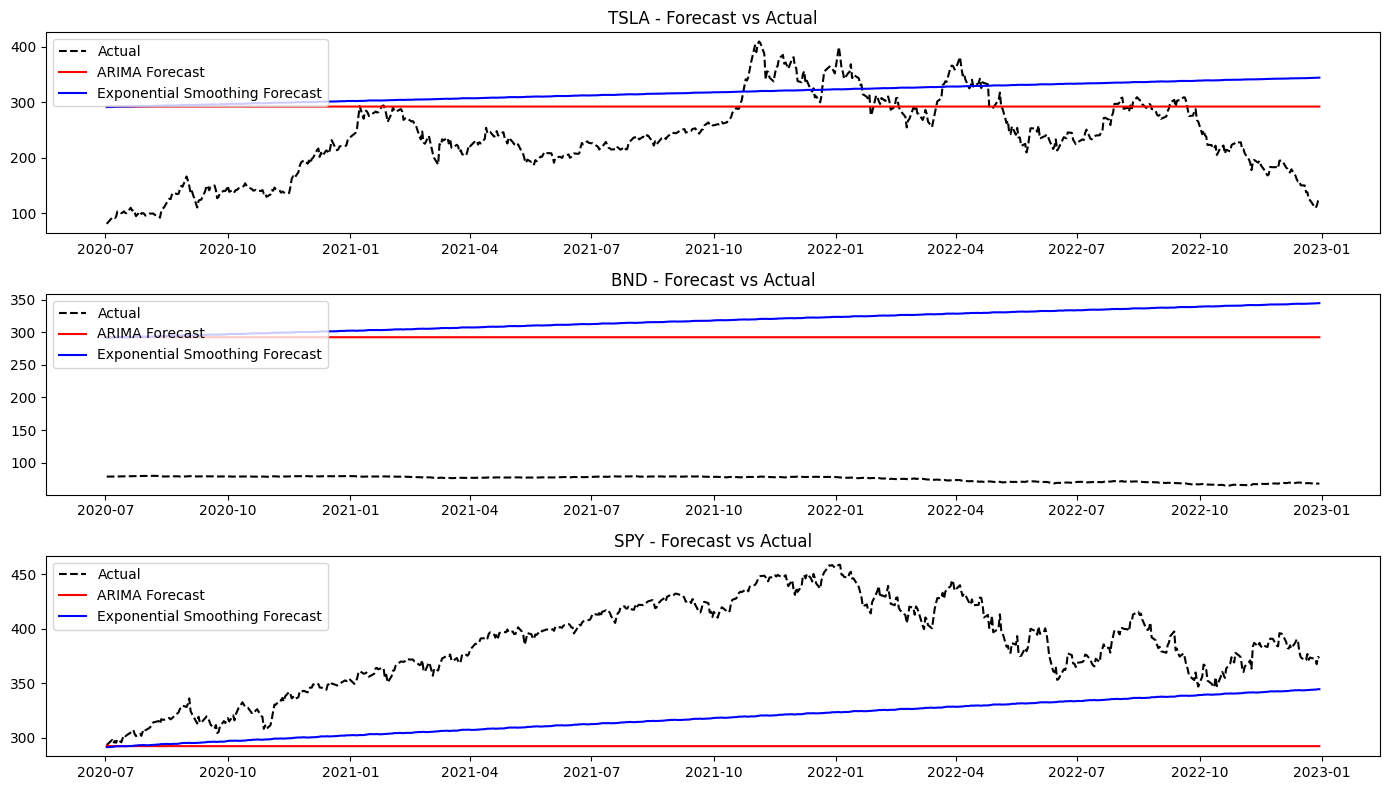

In [ ]:
# Plot the results for TSLA, BND, and SPY
plt.figure(figsize=(14, 8))

for i, model in enumerate(models):
    plt.subplot(len(models), 1, i+1)
    plt.plot(test_data.index, test_data[model], label='Actual', color='black', linestyle='--')
    plt.plot(test_data.index, arima_forecast_tsla, label='ARIMA Forecast', color='red')
    plt.plot(test_data.index, es_forecast_tsla, label='Exponential Smoothing Forecast', color='blue')
    plt.title(f'{model} - Forecast vs Actual')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


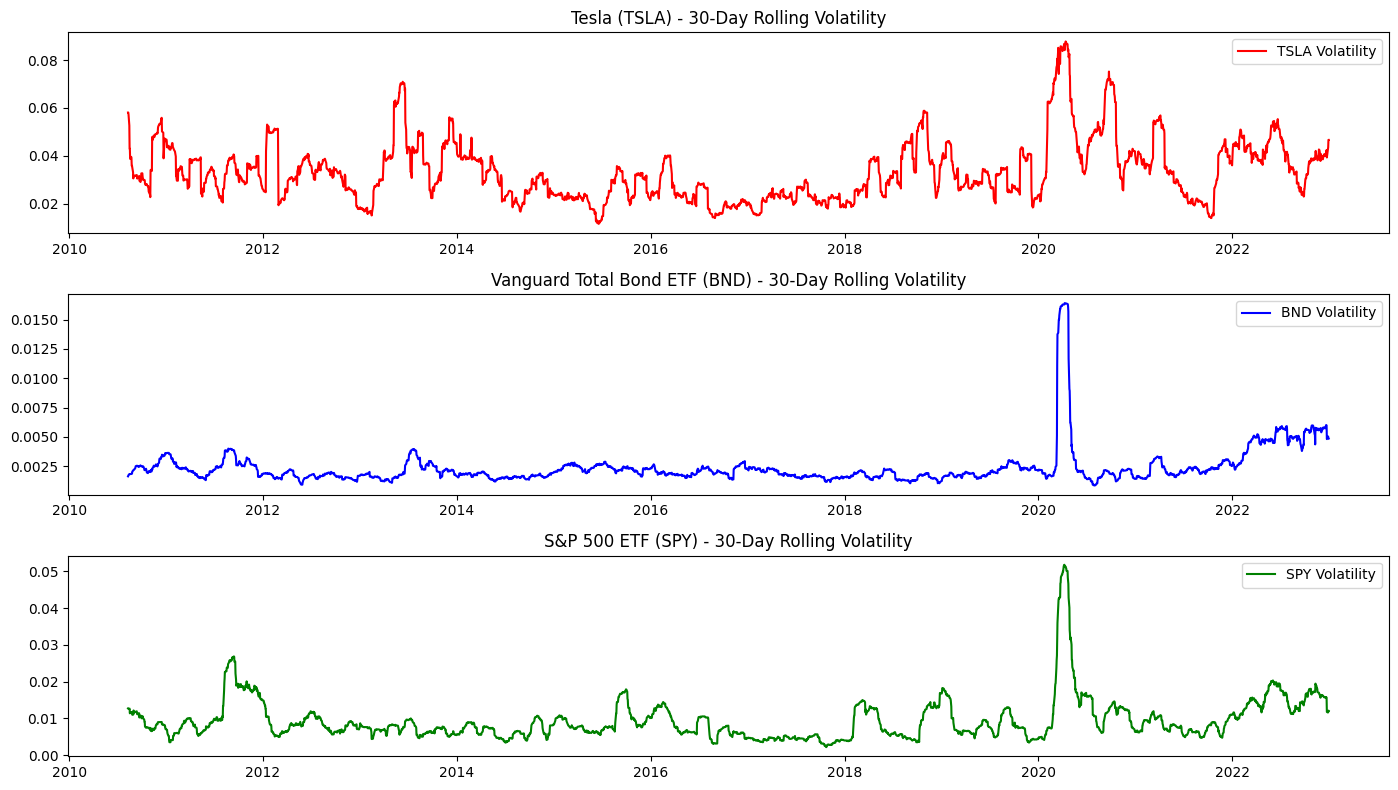

Risk Metrics for TSLA:
Value at Risk (1% confidence): -0.0900
Sharpe Ratio: 0.8935

Risk Metrics for BND:
Value at Risk (1% confidence): -0.0068
Sharpe Ratio: 0.4081

Risk Metrics for SPY:
Value at Risk (1% confidence): -0.0318
Sharpe Ratio: 0.7920


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Define a function to calculate rolling volatility (standard deviation)
def rolling_volatility(returns, window=30):
    return returns.rolling(window=window).std()

# Define a function to calculate Value at Risk (VaR) at the 1% confidence level
def value_at_risk(returns, confidence_level=0.01):
    return returns.quantile(confidence_level)

# Define a function to calculate the Sharpe Ratio (assuming a risk-free rate of 0%)
def sharpe_ratio(returns, risk_free_rate=0):
    return (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)

# Calculate volatility for each asset using a rolling window of 30 days
volatility_tsla = rolling_volatility(daily_returns['TSLA'], window=30)
volatility_bnd = rolling_volatility(daily_returns['BND'], window=30)
volatility_spy = rolling_volatility(daily_returns['SPY'], window=30)

# Calculate VaR for each asset at the 1% level
VaR_tsla = value_at_risk(daily_returns['TSLA'])
VaR_bnd = value_at_risk(daily_returns['BND'])
VaR_spy = value_at_risk(daily_returns['SPY'])

# Calculate Sharpe Ratio for each asset
sharpe_tsla = sharpe_ratio(daily_returns['TSLA'])
sharpe_bnd = sharpe_ratio(daily_returns['BND'])
sharpe_spy = sharpe_ratio(daily_returns['SPY'])

# Plot rolling volatility for TSLA, BND, and SPY
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(volatility_tsla, label='TSLA Volatility', color='red')
plt.title('Tesla (TSLA) - 30-Day Rolling Volatility')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(volatility_bnd, label='BND Volatility', color='blue')
plt.title('Vanguard Total Bond ETF (BND) - 30-Day Rolling Volatility')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(volatility_spy, label='SPY Volatility', color='green')
plt.title('S&P 500 ETF (SPY) - 30-Day Rolling Volatility')
plt.legend()

plt.tight_layout()
plt.show()

# Displaying the Risk Metrics
print(f"Risk Metrics for TSLA:")
print(f"Value at Risk (1% confidence): {VaR_tsla:.4f}")
print(f"Sharpe Ratio: {sharpe_tsla:.4f}\n")

print(f"Risk Metrics for BND:")
print(f"Value at Risk (1% confidence): {VaR_bnd:.4f}")
print(f"Sharpe Ratio: {sharpe_bnd:.4f}\n")

print(f"Risk Metrics for SPY:")
print(f"Value at Risk (1% confidence): {VaR_spy:.4f}")
print(f"Sharpe Ratio: {sharpe_spy:.4f}")


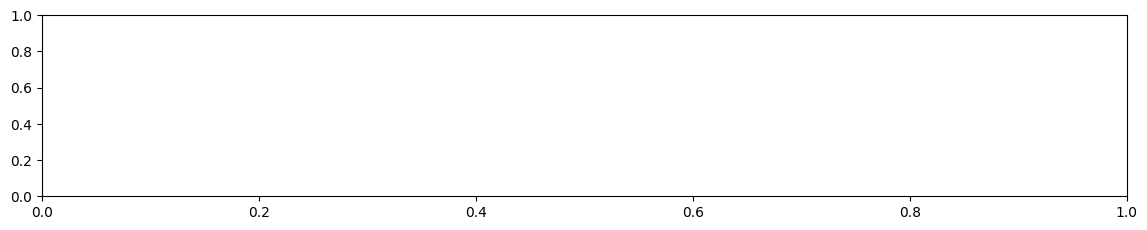

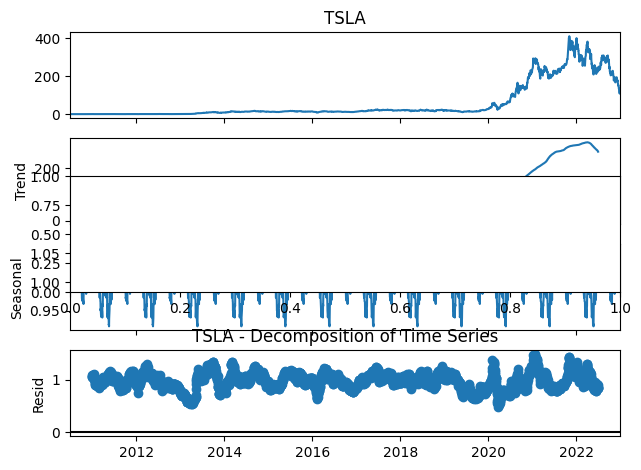

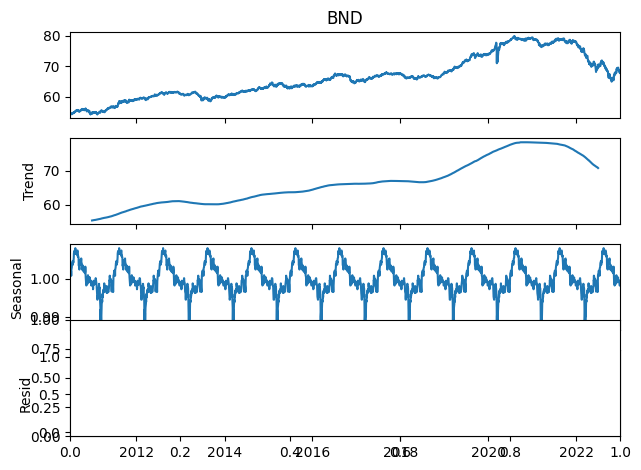

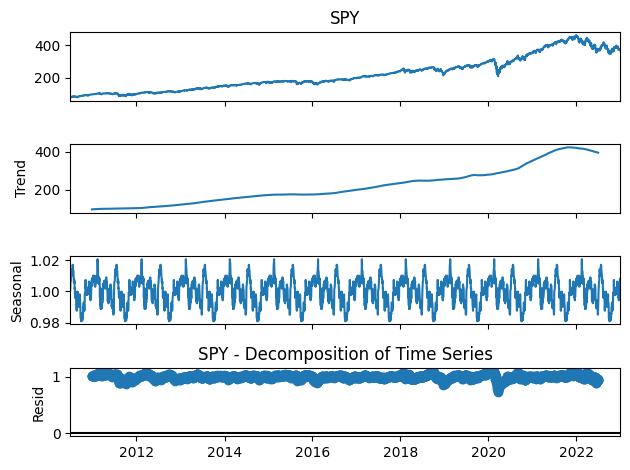

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'data' is your DataFrame containing TSLA, BND, and SPY

# Check for missing values and handle them
data = data.dropna(subset=['TSLA', 'BND', 'SPY'])  # Drop rows where any of the specified columns have NaN

# Alternatively, if you want to fill missing values instead of dropping them:
# data['TSLA'].fillna(method='ffill', inplace=True)
# data['BND'].fillna(method='ffill', inplace=True)
# data['SPY'].fillna(method='ffill', inplace=True)

# Ensure the data has enough points for seasonal_decompose
if len(data) >= 252:  # Check if there are enough data points for at least one full year
    # Decompose the time series data for TSLA, BND, and SPY
    decomposed_tsla = seasonal_decompose(data['TSLA'], model='multiplicative', period=252)
    decomposed_bnd = seasonal_decompose(data['BND'], model='multiplicative', period=252)
    decomposed_spy = seasonal_decompose(data['SPY'], model='multiplicative', period=252)

    # Plot decompositions
    plt.figure(figsize=(14, 8))

    # TSLA decomposition
    plt.subplot(3, 1, 1)
    decomposed_tsla.plot()
    plt.title('TSLA - Decomposition of Time Series')

    # BND decomposition
    plt.subplot(3, 1, 2)
    decomposed_bnd.plot()
    plt.title('BND - Decomposition of Time Series')

    # SPY decomposition
    plt.subplot(3, 1, 3)
    decomposed_spy.plot()
    plt.title('SPY - Decomposition of Time Series')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points for seasonal decomposition. Please provide at least 252 data points.")

In [ ]:
# Calculate Value at Risk (VaR) at 1% confidence level
VaR_tsla = daily_returns['TSLA'].quantile(0.01)
VaR_bnd = daily_returns['BND'].quantile(0.01)
VaR_spy = daily_returns['SPY'].quantile(0.01)

# Calculate Sharpe Ratio (Risk-Free Rate = 0%)
sharpe_tsla = daily_returns['TSLA'].mean() / daily_returns['TSLA'].std() * np.sqrt(252)
sharpe_bnd = daily_returns['BND'].mean() / daily_returns['BND'].std() * np.sqrt(252)
sharpe_spy = daily_returns['SPY'].mean() / daily_returns['SPY'].std() * np.sqrt(252)

print(f"VaR (1% level) for TSLA: {VaR_tsla:.4f}")
print(f"VaR (1% level) for BND: {VaR_bnd:.4f}")
print(f"VaR (1% level) for SPY: {VaR_spy:.4f}")
print(f"Sharpe Ratio for TSLA: {sharpe_tsla:.4f}")
print(f"Sharpe Ratio for BND: {sharpe_bnd:.4f}")
print(f"Sharpe Ratio for SPY: {sharpe_spy:.4f}")


VaR (1% level) for TSLA: -0.0900
VaR (1% level) for BND: -0.0068
VaR (1% level) for SPY: -0.0318
Sharpe Ratio for TSLA: 0.8935
Sharpe Ratio for BND: 0.4081
Sharpe Ratio for SPY: 0.7920
